# 1

Training set with millions of data - Ridge Regression or Elastic Net


# 2

Ridge Regression

It would be hard to estimate alpha

Scaling the data


# 3

No, because it's generally not polynomial. The cost function is convex.


# 4

Yes, the main difference is the time and route it takes for them.

Gradually reduce the learning rate.


# 5

BGD hit a local minimum and it can't estimate for the global minimum.
The modell is overfitting. Need to enlarge the batch-size.
Or use early-stopping.


# 6

No.


# 7

BGD


# 8

The modell is overfitting.

</n> -more testing data

</n> -lower the degree of the modell

</n> -scale the data

-regularize the modell


# 9

High BIAS.

Reduce alpha


$$ 10 $$

a) It can fit better the training data. Can simplify the modell.

b) Eliminates the not necessary features.

c) Lasso Regression can behave badly with too many features.


In [60]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import plotly.express as px
px.defaults.width = 600
import plotly.graph_objs as go

# %matplotlib inline
# import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)


In [38]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)


['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [39]:
X = iris.data[["petal length (cm)", "petal length (cm)"]].values
y = iris["target"].values

In [40]:
bias_array = np.ones(len(X))
X_with_bias = np.c_[bias_array, X]


In [41]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

np.random.seed(69)
rnd_indecies = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indecies[:train_size]]
y_train = y[rnd_indecies[:train_size]]
X_valid = X_with_bias[rnd_indecies[train_size:-test_size]]
y_valid = y[rnd_indecies[train_size:-test_size]]
X_test = X_with_bias[rnd_indecies[-test_size:]]
y_test = y[rnd_indecies[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for any given instance is a one-hot vector)


In [42]:
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]

In [43]:
to_one_hot(y_train[:10])


array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [44]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [45]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std


Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$


In [46]:
def softmax(logits):
    exps = np.exp(logits)
    exps_sum = exps.sum(axis=1, keepdims=True)
    return exps / exps_sum


In [47]:
n_inputs = X_train.shape[1]  # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))  # == 3 (there are 3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.


In [48]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(56)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        # cross entropy cost funtion = xentropy_losses.sum(axis=1).mean()
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        print(epoch, xentropy_losses.sum(axis=1).mean())

    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    Theta = Theta - eta * gradients

0 2.497093248247378
1000 0.12646638576525743
2000 0.12140867841455133
3000 0.12103947982512239
4000 0.12162658786781276
5000 0.12245182855134641


In [49]:
Theta  # modell parameters

array([[-1.83793455,  6.48900405, -3.9923739 ],
       [-7.09782921, -2.42122184,  7.12444744],
       [-6.85716596, -1.21024773,  8.11446067]])

In [50]:
# Let's make predictions for the validation set and check the accuracy score:

logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9666666666666667

In [51]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01  # regularization hyperparameter

np.random.seed(89)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)

    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(epoch, total_loss.round(4))

    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 1.5926
1000 0.3155
2000 0.3155
3000 0.3155
4000 0.3155
5000 0.3155


In [52]:
# Let's make predictions for the validation set and check the accuracy score:

logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9666666666666667

In [53]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.infty

np.random.seed(89)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(20))
    if total_loss.round(7) < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break

    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 1.5925842727415314
729 0.3155
730 0.3155 early stopping!


In [54]:
# Let's make predictions for the validation set and check the accuracy score:

logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9666666666666667

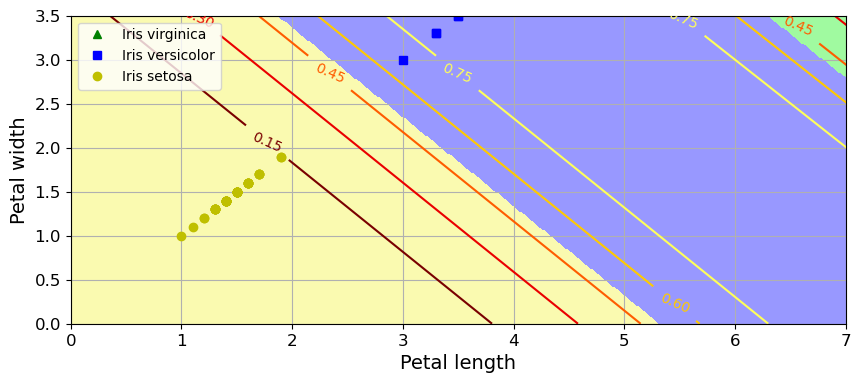

In [61]:
custom_cmap = mpl.colors.ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1), np.linspace(0, 3.5, 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

In [57]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9333333333333333